In [28]:
import IPython
from google.colab import files
from IPython.display import Image

In [29]:
uploaded = files.upload()

Saving bees.jpg to bees (1).jpg
Saving butterfly.jpg to butterfly (1).jpg
Saving candies.jpg to candies (1).jpg
Saving einstein.jpg to einstein (1).jpg
Saving fishes.jpg to fishes (1).jpg
Saving joker.jpg to joker (1).jpg
Saving stars.jpg to stars (1).jpg
Saving sunflowers.jpg to sunflowers (1).jpg


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import cv2 as cv
from itertools import chain
from skimage import io
from skimage import color
from skimage import transform
from scipy.ndimage.filters import convolve
from scipy.ndimage.filters import gaussian_laplace
from scipy.ndimage.filters import generic_filter
from scipy.ndimage.filters import rank_filter
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

In [31]:
def load_and_preprocess(file):
  org_img = cv.imread
  img = cv.imread(file)
  img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  return img/(255)

In [32]:
# Get squared Laplacian response in scale-space.
def get_scale_space(img, init_sigma, levels, method):
  sigma = np.zeros(levels)
  sigma[0] = init_sigma

  k = 1.25
  h = img.shape[0]
  w = img.shape[1]
  scale_space = np.empty((h, w, levels))
    
  # find the size of the matrix
  def increase_matrix_size():
    for i in range(levels):
      size = int(round(6 * sigma[i]))
      if size % 2 == 0:
        size += 1
            
      #creste the filter
      center = int((size + 1)/2 - 1)  
      filter = np.zeros((size, size))
      filter[center][center] = 1

      LoG = sigma[i] * sigma[i] * gaussian_laplace(filter, sigma[i])
      scale_space[:, :, i] = convolve(img, LoG) ** 2

      #renew the sigma
      if (i+1 < levels):
        sigma[i+1] = sigma[i] * k
    
  def downsampling():
    size = int(round(6 * sigma[0]))
    if size % 2 == 0:
      size += 1
        
    center = int((size + 1)/2 - 1)  
    filter = np.zeros((size, size))
    filter[center][center] = 1 
    LoG = gaussian_laplace(filter, sigma[0])
        
    #Down sampling the image
    for i in range(levels):
      new_h = int(h * ((1/k) ** i))
      new_w = int(w * ((1/k) ** i))
      new_img = transform.rescale(img, (1/k) ** i, order = 3)
            
      tmp = convolve(new_img, LoG) ** 2
            
      # Upscaling
      scale_space[:, :, i] = transform.resize(tmp, (h, w), order = 3)
            
      # renew sigmma
      if (i+1 < levels):
        sigma[i+1] = sigma[i] * k
    
  start_time = time.time()
  process = {'increase_matrix_size': increase_matrix_size, 'downsampling': downsampling}
  process[method]()
    
  print("Runtime: %.5s seconds" % (time.time() - start_time))

  return scale_space, sigma

In [33]:
def NMS_2D(scale_space):
  h = scale_space.shape[0]
  w = scale_space.shape[1]
  levels = scale_space.shape[2]
    
  local_max = np.empty((h, w, levels))
    
  for i in range(levels):
    curr_response = scale_space[:,:,i]
    local_max[:, :, i] = rank_filter(curr_response, -1, (3, 3))
    
  return local_max

In [34]:
def NMS_3D(scale_space, sigma):
    
  local_max = NMS_2D(scale_space)
    
  h = local_max.shape[0]
  w = local_max.shape[1]
  levels = local_max.shape[2]
    
  global_max = np.zeros(local_max.shape)
    
  for i in range(h):
    for j in range(w):
      max_value = np.amax(local_max[i, j, :])
      max_index = np.argmax(local_max[i, j, :])
      global_max[i, j, max_index] = max_value

  for i in range(levels):
    global_max[:, :, i] = np.where((global_max[:, :, i] == scale_space[:, :, i]), global_max[:, :, i], 0)

  return global_max

In [35]:
def get_mask(h, w, levels, sigma):
  #make masks for the max points
  mask = np.zeros((h, w, levels))
  for i in range(levels):
    center = int(math.ceil(sigma[i] * math.sqrt(2)))
    mask[center + 1 : h - center, center + 1: w - center] = 1
  return mask

In [36]:
def get_radius(sigma, num_radius): 
  return np.ones(num_radius) * math.sqrt(2) * sigma

In [37]:
def detect_blob(global_max, threshold, sigma):
  levels = global_max.shape[2]
  mask = get_mask(global_max.shape[0], global_max.shape[1], levels, sigma)

  row = []
  col = []
  radius = []
    
  for i in range(levels):
    global_max[:, :, i] = np.where((global_max[:, :, i] > threshold) & (mask[:, :, i] == 1), 1, 0)
        
    row.append(list(np.where(global_max[:, :, i] == 1)[0]))
    col.append(list(np.where(global_max[:, :, i] == 1)[1]))
        
    radius.append(list(get_radius(sigma[i], len(row[i]))))
    
  row = list(chain.from_iterable(row))
  col = list(chain.from_iterable(col))
  radius = list(chain.from_iterable(radius))

  return row, col, radius

In [38]:
def show_and_save_all_circles(img, dx, dy, radius, img_name, method, threshold, color='r'):
  fig, ax = plt.subplots()
  ax.imshow(img, cmap='gray')
  ax.xaxis.set_visible(False)
  ax.yaxis.set_visible(False)
  for x, y, r in zip(dx, dy, radius):
    circle = Circle((x, y), r, color=color, fill=False)
    ax.add_patch(circle)

  plt.savefig(img_name.split('.')[0] + '_' + method + '.jpg')
  plt.show()

In [39]:
def run_detection(img_name, method, levels, threshold, init_sigma):
  k = 1.25

  file = img_name
  img = load_and_preprocess(file)

  scale_space, sigma = get_scale_space(img, init_sigma, levels, method)
    
  global_max = NMS_3D(scale_space, sigma)

  row_index, col_index, radius = detect_blob(global_max, threshold, sigma)
    
  show_and_save_all_circles(img, col_index, row_index, radius, img_name, method, threshold)

In [40]:
methods = ['increase_matrix_size', 'downsampling']
levels = 12  
init_sigma = 2 
thresholds = np.array([0.0028, 0.00015])

Runtime: 36.76 seconds


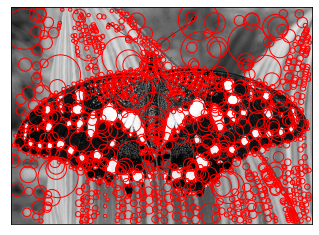

In [41]:
image_name = 'butterfly.jpg'
run_detection(image_name, methods[0], levels, thresholds[0], init_sigma)


Runtime: 0.843 seconds


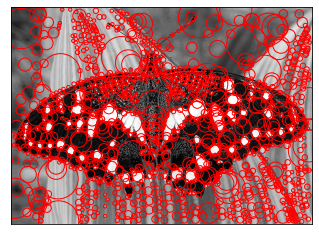

In [43]:
image_name = 'butterfly.jpg'
run_detection(image_name, methods[1], levels, thresholds[1], 2)

Runtime: 37.76 seconds


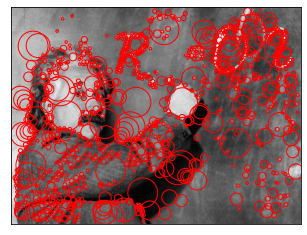

Runtime: 1.339 seconds


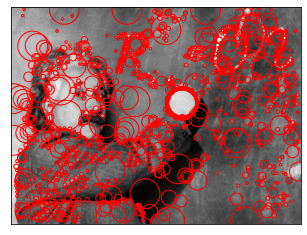

Runtime: 26.12 seconds


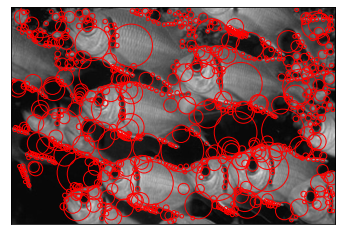

Runtime: 0.869 seconds


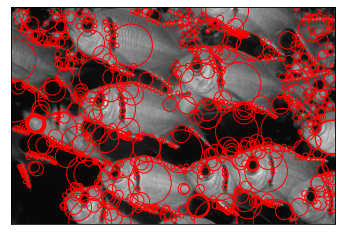

In [44]:
image_name = 'einstein.jpg'
run_detection(image_name, methods[0], levels, thresholds[0], 2)
image_name = 'einstein.jpg'
run_detection(image_name, methods[1], levels, thresholds[1], 2)

image_name = 'fishes.jpg'
run_detection(image_name, methods[0], levels, thresholds[0], 2)
image_name = 'fishes.jpg'
run_detection(image_name, methods[1], levels, thresholds[1], 2)

Runtime: 21.18 seconds


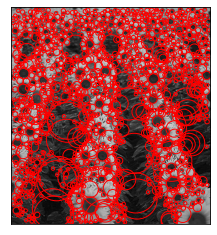

Runtime: 0.562 seconds


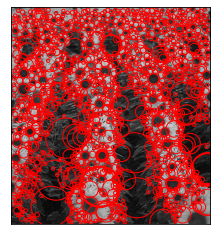

Runtime: 15.99 seconds


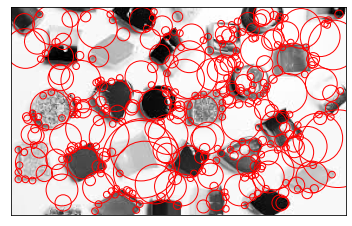

Runtime: 0.281 seconds


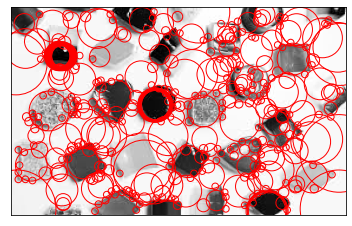

In [45]:
image_name = 'sunflowers.jpg'
run_detection(image_name, methods[0], levels, thresholds[0], 2)
image_name = 'sunflowers.jpg'
run_detection(image_name, methods[1], levels, thresholds[1], 2)

image_name = 'candies.jpg'
run_detection(image_name, methods[0], levels, thresholds[0], 2)
image_name = 'candies.jpg'
run_detection(image_name, methods[1], levels, thresholds[1], 2)

Runtime: 15.84 seconds


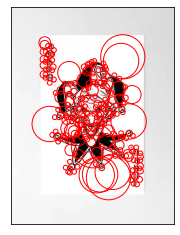

Runtime: 0.293 seconds


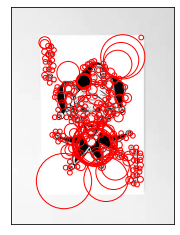

Runtime: 15.73 seconds


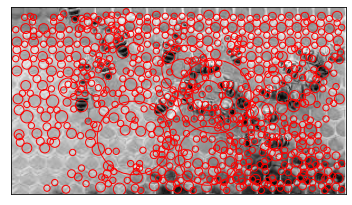

Runtime: 0.265 seconds


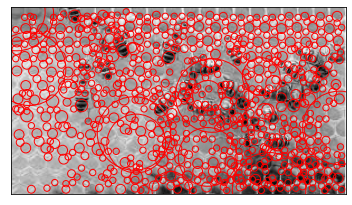

In [46]:
image_name = 'joker.jpg'
run_detection(image_name, methods[0], levels, thresholds[0], 2)
image_name = 'joker.jpg'
run_detection(image_name, methods[1], levels, thresholds[1], 2)

image_name = 'bees.jpg'
run_detection(image_name, methods[0], levels, thresholds[0], 2)
image_name = 'bees.jpg'
run_detection(image_name, methods[1], levels, thresholds[1], 2)

Runtime: 16.60 seconds


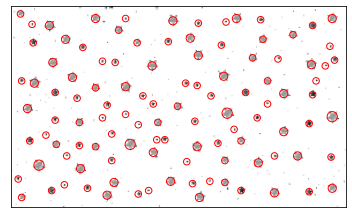

Runtime: 0.427 seconds


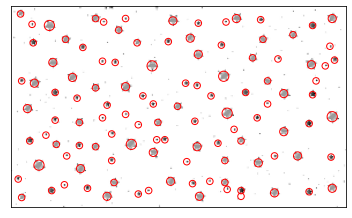

In [47]:
image_name = 'stars.jpg'
run_detection(image_name, methods[0], levels, thresholds[0], 2)
image_name = 'stars.jpg'
run_detection(image_name, methods[1], levels, thresholds[1], 2)